In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
device=torch.device('cude' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# transform images before using them
# resize them to 128 * 128
# turn them to tensors
# noramlize them

tf= transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

download dataset from: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

In [5]:
train_dl=DataLoader(
    datasets.ImageFolder('data/Training',tf),
    # 32 images at a time
    batch_size=32,shuffle=True,num_workers=4 ,pin_memory=True  # to speed up
)

test_dl=DataLoader(
    datasets.ImageFolder('data/Testing',tf),
    # 32 images at a time
    batch_size=32,shuffle=False,num_workers=4 ,pin_memory=True  # to speed up
)

In [6]:
model=nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1),nn.ReLU(),nn.MaxPool2d(2),
    nn.Conv2d(32,64,3,1,1),nn.ReLU(),nn.MaxPool2d(2),
    nn.Conv2d(64,128,3,1,1),nn.ReLU(),nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128*16*16,256),nn.ReLU(),nn.Dropout(0.5),
    nn.Linear(256,4) # 4 classes
).to(device)



In [7]:
# optimizer

opt=optim.AdamW(model.parameters(),1e-4)
loss_fn=nn.CrossEntropyLoss()



In [8]:
model.train()

for epoch in range(25):
    running_loss=0
    for x,y in train_dl:
        opt.zero_grad()
        loss=loss_fn(model(x.to(device)),y.to(device))
        loss.backward()

        running_loss+= loss
        opt.step()

    print(f'Epoch {epoch+1}: Loss was {running_loss} ')

f:\PRGRAMME\PYTHON 3.12\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1: Loss was 153.64332580566406 
Epoch 2: Loss was 102.20639038085938 
Epoch 3: Loss was 87.64677429199219 


KeyboardInterrupt: 

In [9]:
model.eval()
test_loss,correct=0.0,0

with torch.no_grad():
    for x,y in test_dl:
        x,y = x.to(device),y.to(device)

        logits = model(x)
        test_loss += loss_fn(logits,y).item()*y.size(0)

        preds=logits.argmax(dim=1)
        correct+= (preds == y).sum().item()

test_loss /= len(test_dl.dataset)
accuracy = 100.0*correct/len(test_dl.dataset)

print("Test loss:",test_loss, "Test Accuracy",accuracy,"%")


f:\PRGRAMME\PYTHON 3.12\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test loss: 0.521764722019775 Test Accuracy 78.26086956521739 %


Visualize Random Image

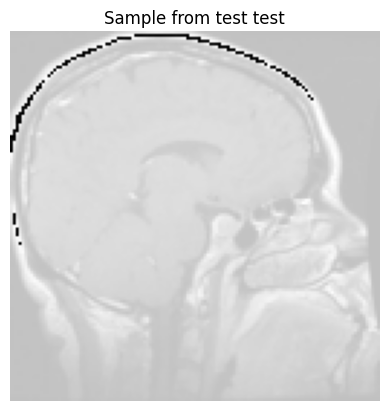

Prediction class: pituitary
Ground-truth: pituitary


In [12]:
import random
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

model.eval()
idx=random.randrange(len(test_dl.dataset))
img,label = test_dl.dataset[idx]

unnorm = img*0.5*0.5
plt.imshow(to_pil_image(unnorm))
plt.axis('off')
plt.title('Sample from test test')
plt.show()

with torch.no_grad():
    logits = model(img.unsqueeze(0).to(device))
    pred=logits.argmax(1).item()

class_names=test_dl.dataset.classes
print(f"Prediction class: {class_names[pred]}")
print(f"Ground-truth: {class_names[label]}")